参考：<https://qiita.com/kogepan102/items/122b2862ad5a51180656>  
データ：<https://www.mvtec.com/company/research/datasets/mvtec-ad/>  
論文：Iterative energy-based projection on a normal data manifold for anomaly localization

In [1]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils import data
from torchvision import transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import matplotlib.pyplot as plt

## Dataset

In [2]:
class MVTecAD(data.Dataset):
    """Dataset class for the MVTecAD dataset."""

    def __init__(self, image_dir, transform):
        """Initialize and preprocess the MVTecAD dataset."""
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, index):
        """Return one image"""
        filename = "{:03}.png".format(index)
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image)

    def __len__(self):
        """Return the number of images."""
        return len(os.listdir(self.image_dir))


def return_MVTecAD_loader(image_dir, batch_size=256, train=True):
    """Build and return a data loader."""
    transform = []
    transform.append(T.Resize((512, 512)))
    transform.append(T.RandomCrop((128,128)))
    transform.append(T.RandomHorizontalFlip(p=0.5))
    transform.append(T.RandomVerticalFlip(p=0.5))    
    transform.append(T.ToTensor())
    transform = T.Compose(transform)

    dataset = MVTecAD(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=train)
    return data_loader

In [13]:
train_loader = return_MVTecAD_loader("./mvtec_anomaly_detection/grid/train/good/")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 42
out_dir = './logs'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

cuda


## Model

In [14]:
class VAE(nn.Module):

    def __init__(self, z_dim=128):
        super(VAE, self).__init__()

        # encode
        self.conv_e = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),    # 128 ⇒ 64
            nn.BatchNorm2d(32),            
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64 ⇒ 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32 ⇒ 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),     
        )
        self.fc_e = nn.Sequential(
            nn.Linear(128 * 16 * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, z_dim*2),
        )

        # decode
        self.fc_d = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 128 * 16 * 16),
            nn.LeakyReLU(0.2)
        )
        self.conv_d = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.z_dim = z_dim

    def encode(self, input):
        x = self.conv_e(input)
        x = x.view(-1, 128*16*16)
        x = self.fc_e(x)
        return x[:, :self.z_dim], x[:, self.z_dim:]  # mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.fc_d(z)
        h = h.view(-1, 128, 16, 16)
        return self.conv_d(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        self.mu = mu
        self.logvar = logvar
        return self.decode(z)

In [5]:
model = VAE(z_dim=512).to(device)

## Train

VAEのloss

$$
\begin{aligned}
\log p(\boldsymbol{x}) &= \log \mathbb{E}_{\boldsymbol{z} \sim q(\boldsymbol{z}|\boldsymbol{x})}\left[\frac{p(\boldsymbol{x}|\boldsymbol{z})p(\boldsymbol{z})}{q(\boldsymbol{z}|\boldsymbol{x})}\right] \\
& \geq \mathbb{E}_{\boldsymbol{z} \sim q(\boldsymbol{z}|\boldsymbol{x})} \log p(\boldsymbol{x}|\boldsymbol{z}) - D_{\mathrm{KL}}\left( q(\boldsymbol{z}|\boldsymbol{x})\parallel p(\boldsymbol{z})\right) = -\mathcal{L}(\boldsymbol{x})
\end{aligned}
$$

Matsubaraのloss（reconstruction error）

$$
\begin{aligned}
\mathcal{L}_{r}(\boldsymbol{x}) &= -\mathbb{E}_{\boldsymbol{z} \sim q(\boldsymbol{z}|\boldsymbol{x})} \log p(\boldsymbol{x}|\boldsymbol{z}) \\
&= -\frac{1}{N}\sum_{i=1}^N\log p(\boldsymbol{x}|\boldsymbol{z}^{(i)}) \\
&= -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^{ H\times W\times C} \left\{ x_j \ln \mathrm{Dec}(\boldsymbol{z}^{(i)})_j + (1-x_j) \ln (1-\mathrm{Dec}(\boldsymbol{z}^{(i)})_j)  \right\}  \ (\mathrm{ベルヌーイ分布}) \\
&\simeq -\sum_{j=1}^{ H\times W\times C} \left\{ x_j \ln \mathrm{Dec}(\boldsymbol{z})_j + (1-x_j) \ln (1-\mathrm{Dec}(\boldsymbol{z})_j)  \right\} \ (N=1 \mathrm{近似})
\end{aligned}
$$

In [15]:
def loss_function(recon_x, x, mu, logvar):
    recon = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data, model.mu, model.logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader.dataset)

    return train_loss    


# gif作成用
def iterative_plot(x_t, j):
    plt.figure(figsize=(15, 4))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_t[i][0], cmap=plt.cm.gray)
    plt.subplots_adjust(wspace=0., hspace=0.)        
    plt.savefig("./results/{}.png".format(j))
    plt.show()

In [7]:
optimizer = optim.Adam(model.parameters(), lr=5e-4)
num_epochs = 500

for epoch in range(num_epochs):
    loss = train(epoch)
    print('epoch [{}/{}], train loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss))

epoch [1/500], train loss: 13726.5128
epoch [2/500], train loss: 13368.2701
epoch [3/500], train loss: 12414.3165
epoch [4/500], train loss: 11976.2450
epoch [5/500], train loss: 11723.4777
epoch [6/500], train loss: 11593.4719
epoch [7/500], train loss: 11504.1401
epoch [8/500], train loss: 11452.9615
epoch [9/500], train loss: 11406.4217
epoch [10/500], train loss: 11371.0809
epoch [11/500], train loss: 11348.3006
epoch [12/500], train loss: 11323.2264
epoch [13/500], train loss: 11309.3255
epoch [14/500], train loss: 11296.3473
epoch [15/500], train loss: 11291.2905
epoch [16/500], train loss: 11283.1601
epoch [17/500], train loss: 11270.0839
epoch [18/500], train loss: 11271.1802
epoch [19/500], train loss: 11261.7422
epoch [20/500], train loss: 11256.5463
epoch [21/500], train loss: 11254.3567
epoch [22/500], train loss: 11250.9995
epoch [23/500], train loss: 11248.6450
epoch [24/500], train loss: 11242.1336
epoch [25/500], train loss: 11243.4333
epoch [26/500], train loss: 11237.

epoch [209/500], train loss: 10721.6132
epoch [210/500], train loss: 10724.2490
epoch [211/500], train loss: 10717.8558
epoch [212/500], train loss: 10728.2918
epoch [213/500], train loss: 10710.6103
epoch [214/500], train loss: 10718.4305
epoch [215/500], train loss: 10723.3468
epoch [216/500], train loss: 10712.2885
epoch [217/500], train loss: 10720.7954
epoch [218/500], train loss: 10714.8038
epoch [219/500], train loss: 10712.8010
epoch [220/500], train loss: 10716.8590
epoch [221/500], train loss: 10719.2423
epoch [222/500], train loss: 10718.8867
epoch [223/500], train loss: 10714.6475
epoch [224/500], train loss: 10709.2595
epoch [225/500], train loss: 10712.3614
epoch [226/500], train loss: 10713.4190
epoch [227/500], train loss: 10718.1992
epoch [228/500], train loss: 10714.6553
epoch [229/500], train loss: 10710.5630
epoch [230/500], train loss: 10715.5290
epoch [231/500], train loss: 10709.7406
epoch [232/500], train loss: 10718.9588
epoch [233/500], train loss: 10707.2157


epoch [414/500], train loss: 10629.2814
epoch [415/500], train loss: 10637.1500
epoch [416/500], train loss: 10643.7339
epoch [417/500], train loss: 10630.2676
epoch [418/500], train loss: 10639.8877
epoch [419/500], train loss: 10638.6044
epoch [420/500], train loss: 10630.3251
epoch [421/500], train loss: 10631.4856
epoch [422/500], train loss: 10633.3069
epoch [423/500], train loss: 10629.7008
epoch [424/500], train loss: 10631.3157
epoch [425/500], train loss: 10638.2797
epoch [426/500], train loss: 10634.8234
epoch [427/500], train loss: 10625.3722
epoch [428/500], train loss: 10634.0609
epoch [429/500], train loss: 10635.7493
epoch [430/500], train loss: 10629.0436
epoch [431/500], train loss: 10627.4730
epoch [432/500], train loss: 10630.4789
epoch [433/500], train loss: 10625.8268
epoch [434/500], train loss: 10630.6521
epoch [435/500], train loss: 10634.3269
epoch [436/500], train loss: 10627.8114
epoch [437/500], train loss: 10635.1674
epoch [438/500], train loss: 10625.0092


In [10]:
model.to("cpu")
torch.save(model.state_dict(), "./weight.pth")

In [5]:
model = VAE(z_dim=512)
model.load_state_dict(torch.load("./weight.pth"))
model.to(device)

VAE(
  (conv_e): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc_e): Sequential(
    (0): Linear(in_features=32768, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (fc_d): Sequential(
    (0): Linear(in_features=512, out_features=1024

## Inference

In [6]:
os.listdir("./mvtec_anomaly_detection/grid/test/")

['metal_contamination', 'broken', 'glue', 'thread', 'bent', 'good']

In [7]:
model.eval()
test_loader = return_MVTecAD_loader("./mvtec_anomaly_detection/grid/test/metal_contamination/", batch_size=10, train=False)

In [22]:
x_0 = iter(test_loader).next()  # original data
model.eval()

with torch.no_grad():
    x_vae = model(x_0.to(device)).detach().cpu().numpy()  # 再構成 data

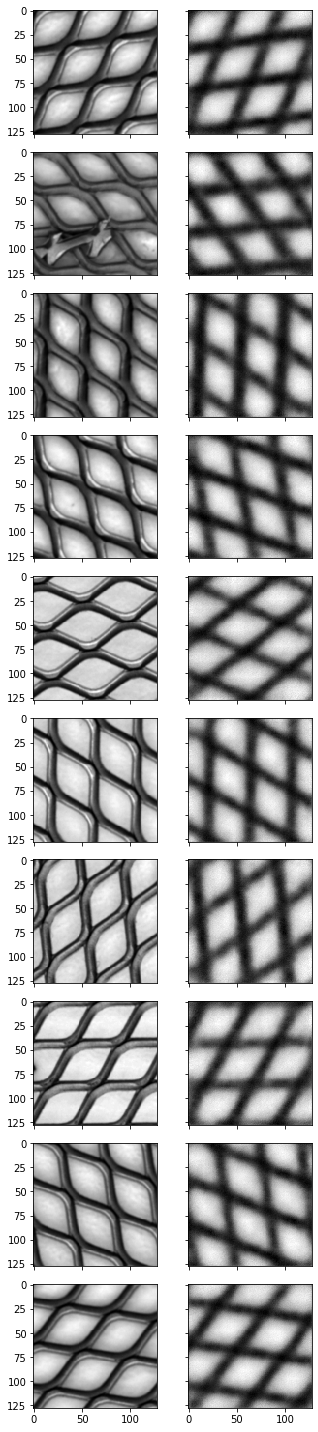

In [23]:
fig, axes= plt.subplots(10, 2, figsize=(5, 20), sharex=True, sharey=True)

for i in range(10):
    axes[i][0].imshow(x_0[i, 0], 'gray')
    axes[i][1].imshow(x_vae[i, 0], 'gray')

plt.tight_layout()
plt.show()

## 事後最適化

$\boldsymbol{x}_0$はoriginal画像

エネルギー関数
$$
E(x_t) = \mathcal{L}_r(\boldsymbol{x}_t) + \lambda ||\boldsymbol{x}_t-\boldsymbol{x}_0||_1
$$

実空間での最適化
$$
\boldsymbol{x}_{t+1} = \boldsymbol{x}_t - \alpha\cdot\left(\nabla_{\boldsymbol{x}} E(\boldsymbol{x}_t)\odot (\boldsymbol{x}_t - f_\mathrm{VAE}(\boldsymbol{x}_t))^2\right)
$$

In [24]:
def plot_optimization(x, alpha=0.05, lamda=1, n_iter=15, recon=False):
    x = x.to(device).requires_grad_(True)
    x_0 = x.to(device).detach().clone()

    for i in range(n_iter):
        recon_x = model(x).detach()
        loss = F.binary_cross_entropy(x, recon_x, reduction='sum') + lamda * torch.abs(x - x_0).sum()
        loss.backward(retain_graph=True)
        
        with torch.no_grad():
            x_grad = x.grad.data
            x = x - alpha * x_grad * (x - recon_x) ** 2
        
        x = torch.clamp(x, 0.0, 1.0)  # 0-1でクリップする binary_cross_entropyでエラーになるため
        if recon:
            iterative_plot(recon_x.detach().cpu().numpy(), i)  # 再構成画像
        else:
            iterative_plot(x.detach().cpu().numpy(), i)
            
        x.requires_grad_(True)

    losses_1, losses_2 = [], []
    for i in range(len(x_0)):
        losses_1.append(int(F.binary_cross_entropy(x[i], x_0[i], reduction='sum').detach().cpu().item()))
        losses_2.append(int(((x[i]-x_0[i])**2).sum().cpu().item()))
    print(losses_1)
    print(losses_2)

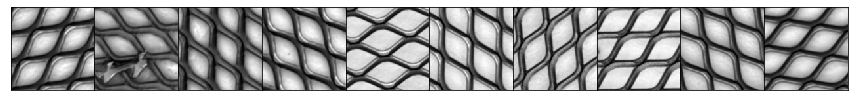

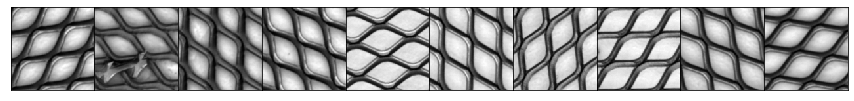

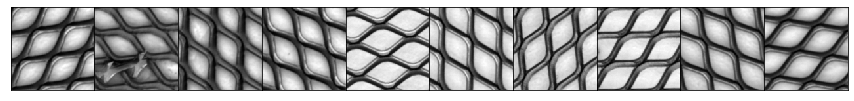

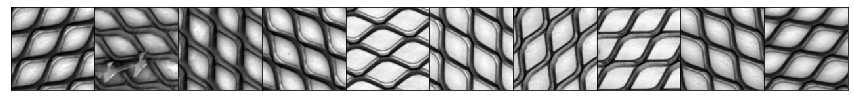

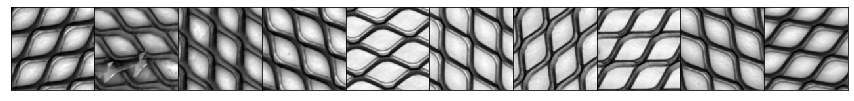

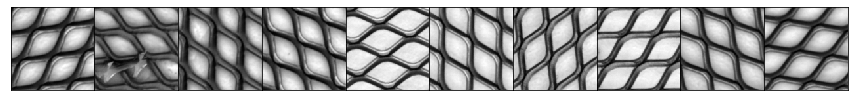

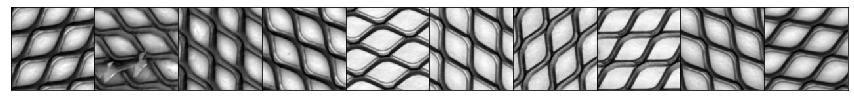

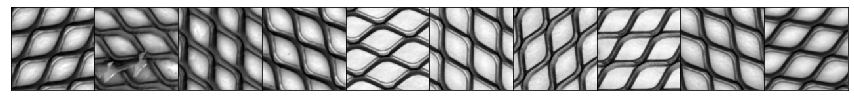

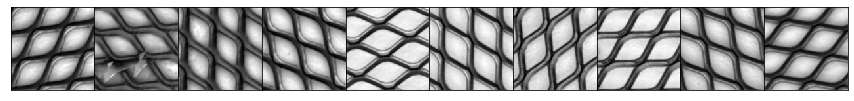

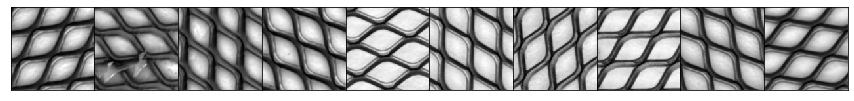

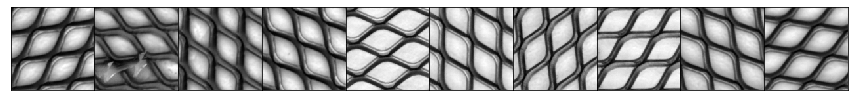

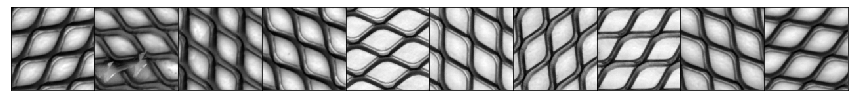

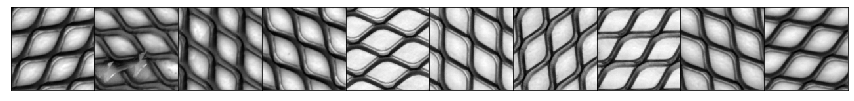

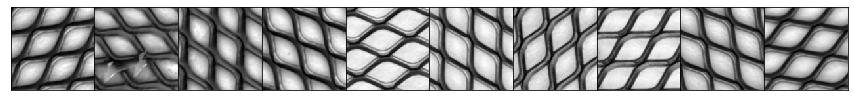

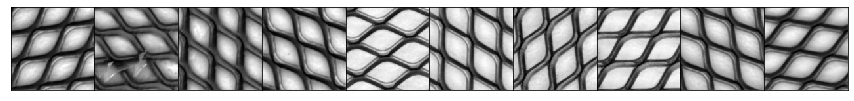

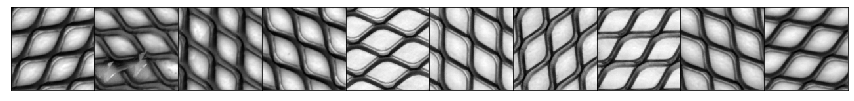

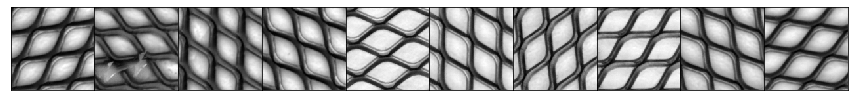

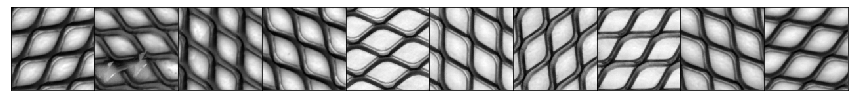

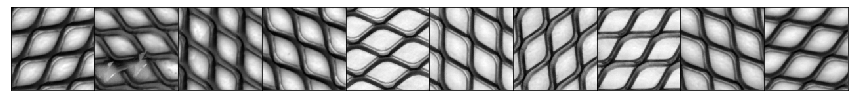

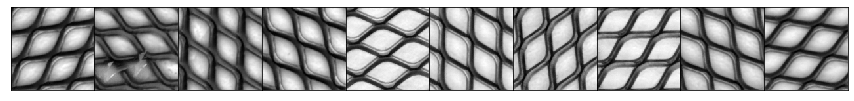

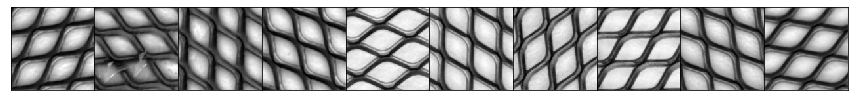

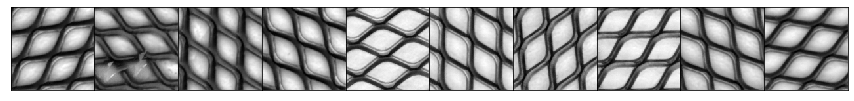

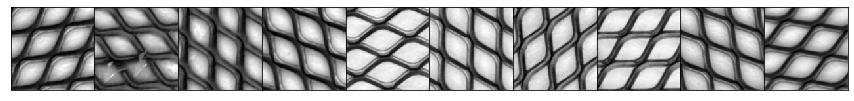

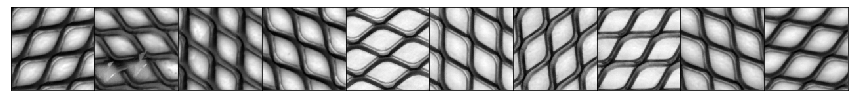

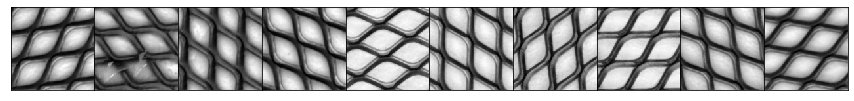

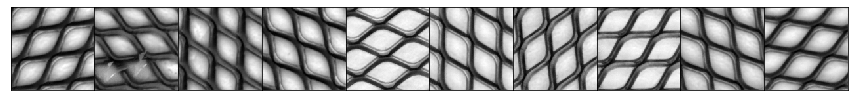

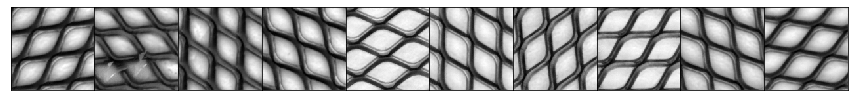

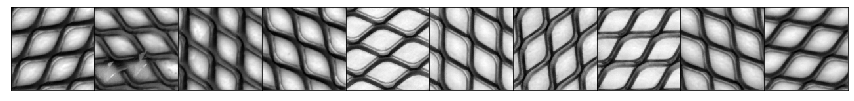

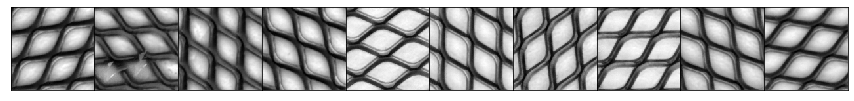

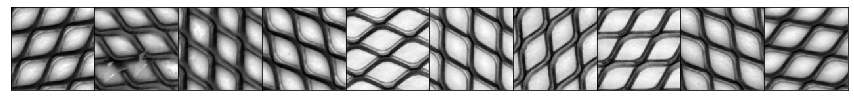

[10293, 10543, 10406, 10416, 10540, 10551, 10690, 10713, 10355, 10147]
[8, 50, 8, 6, 23, 11, 8, 10, 10, 9]


In [25]:
plot_optimization(x_0, alpha=0.25, lamda=0.00001, n_iter=30)

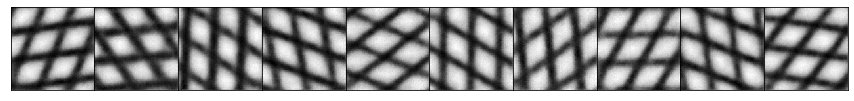

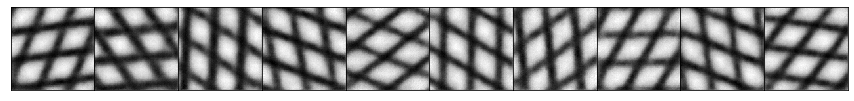

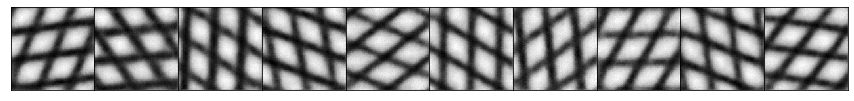

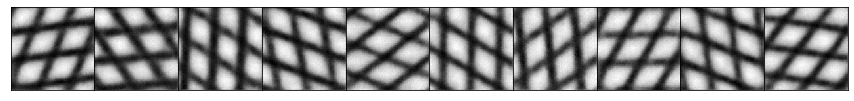

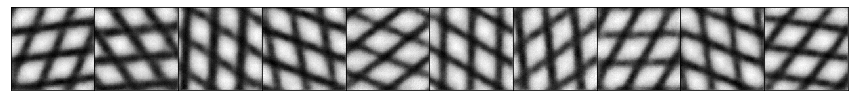

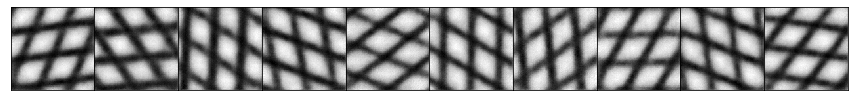

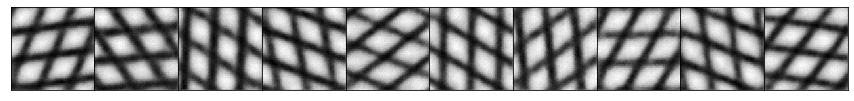

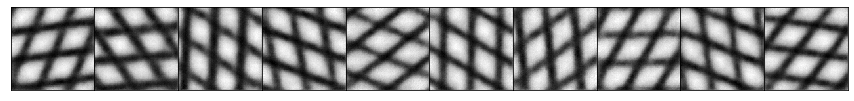

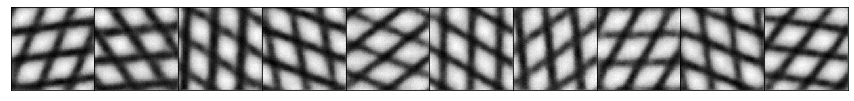

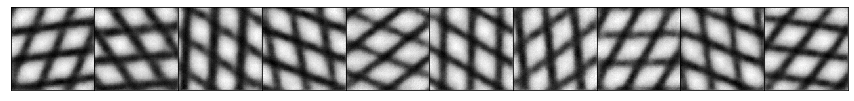

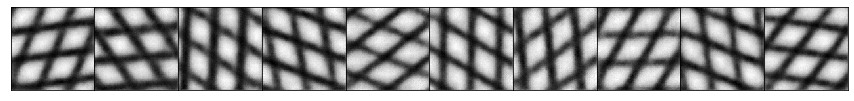

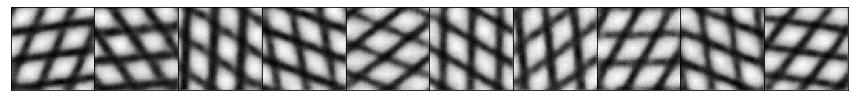

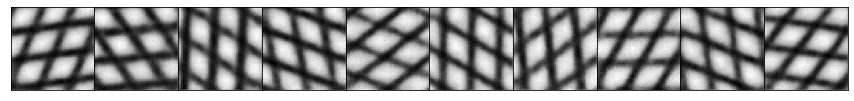

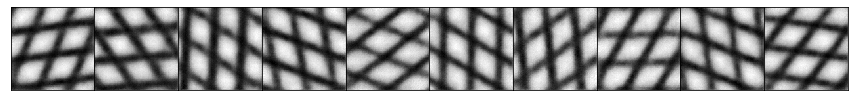

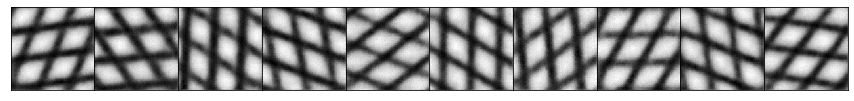

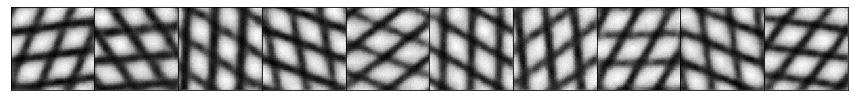

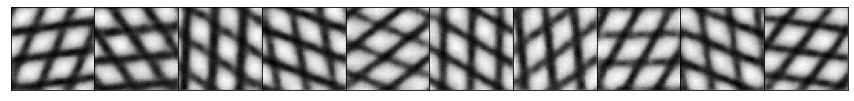

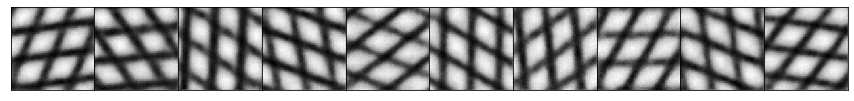

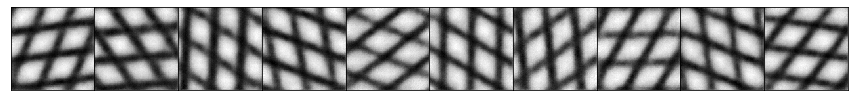

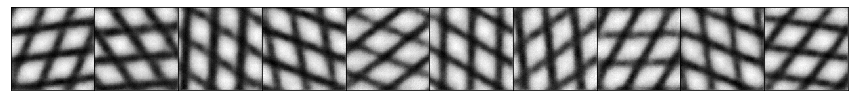

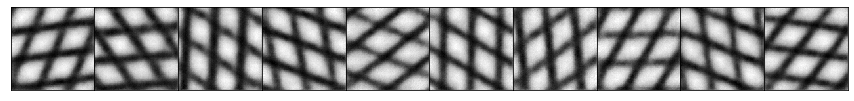

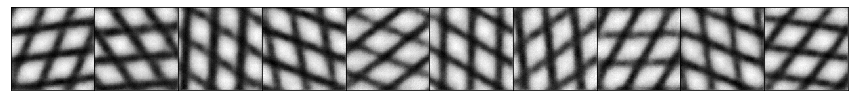

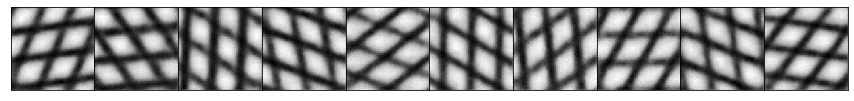

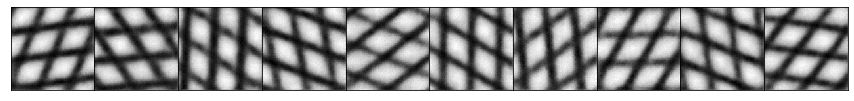

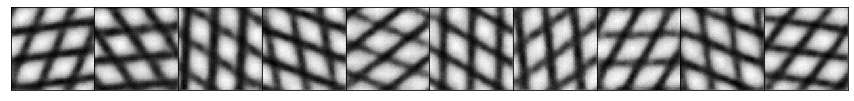

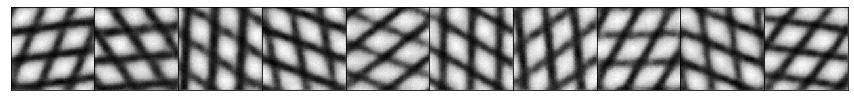

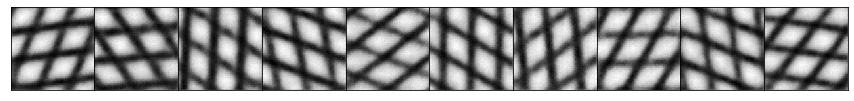

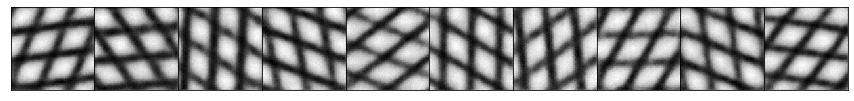

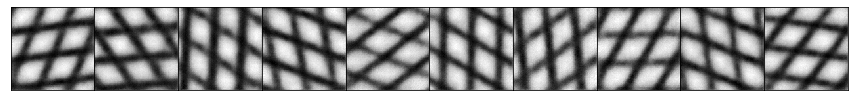

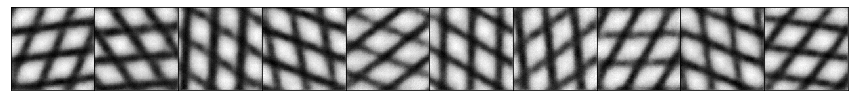

[10293, 10543, 10406, 10416, 10540, 10551, 10690, 10713, 10355, 10147]
[8, 50, 8, 6, 23, 11, 8, 10, 10, 9]


In [26]:
plot_optimization(x_0, alpha=0.25, lamda=0.00001, n_iter=30, recon=True)